In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [20]:
import cactas as C
import os
import mahotas as mh
import nibabel as nib
import nrrd
import skimage.morphology
import cv2

In [3]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'

In [4]:
images, labels = C.Helper.load_data(DATAPATH)

In [5]:
X_train, y_train, X_test, y_test = C.Helper.split_patients(images, labels)

In [6]:
TS_PATH='TS'

In [7]:
segment_62_l = TS_PATH + "/62/common_carotid_artery_left.nii.gz"
segment_62_r = TS_PATH + "/62/common_carotid_artery_right.nii.gz"
img_62_l = nib.load(segment_62_l)
img_62_r = nib.load(segment_62_r)
data_62_l = img_62_l.get_fdata()
data_62_r = img_62_r.get_fdata()

In [8]:
combined = data_62_l + data_62_r

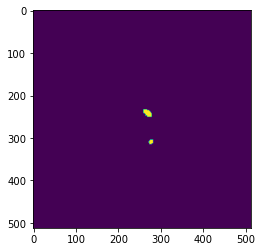

In [15]:
plt.imshow(combined[:,:,54])
plt.show()

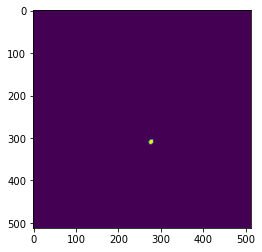

In [16]:
plt.imshow(data_62_l[:,:,54])
plt.show()

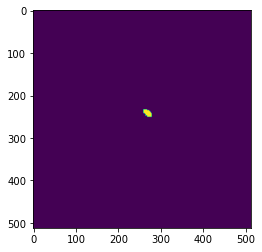

In [17]:
plt.imshow(data_62_r[:,:,54])
plt.show()

In [23]:
kernel = np.ones((51, 51), np.uint8) 

In [24]:
img_dilation = cv2.dilate(combined, kernel, iterations=1) 

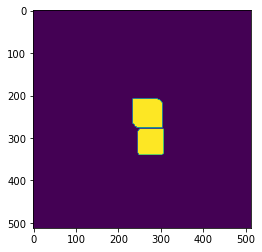

In [25]:
plt.imshow(img_dilation[:,:,54])
plt.show()

In [26]:
binary_mask = (img_dilation > 0).astype(np.uint8) * 255

In [31]:
image, header = nrrd.read(DATAPATH + "/" + X_train[23])

In [32]:
label, header = nrrd.read(DATAPATH + "/" + y_train[23])

In [33]:
result = image * binary_mask

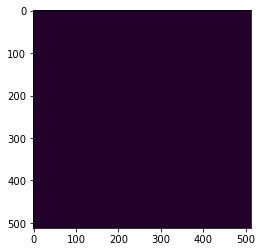

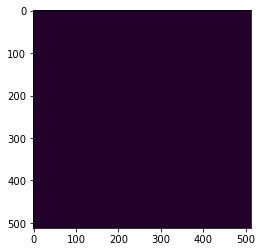

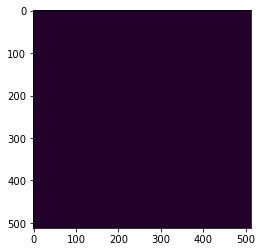

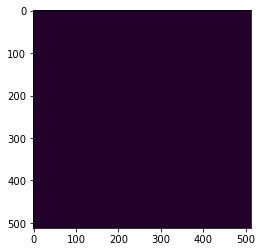

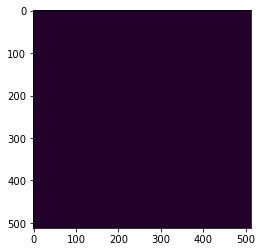

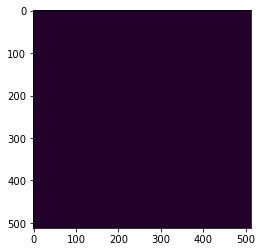

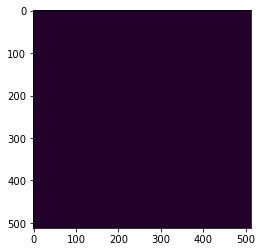

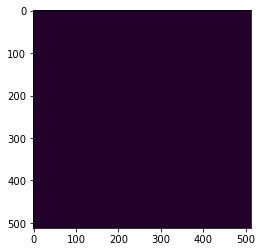

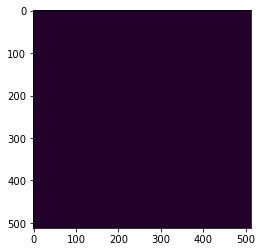

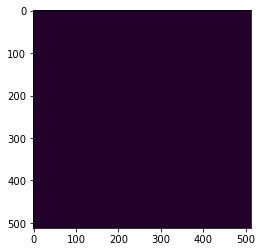

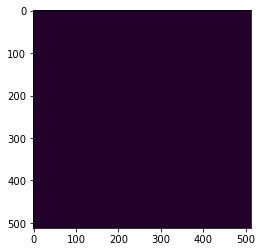

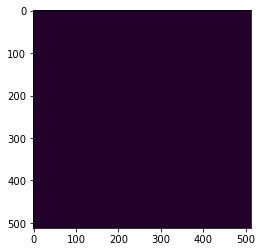

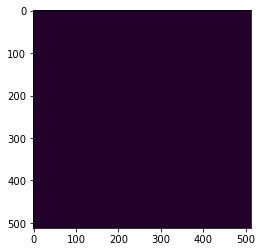

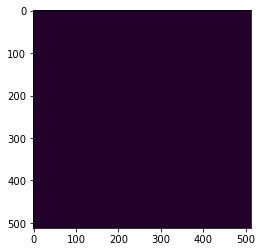

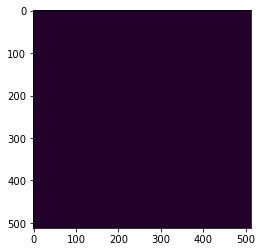

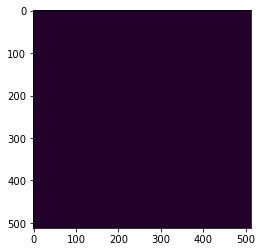

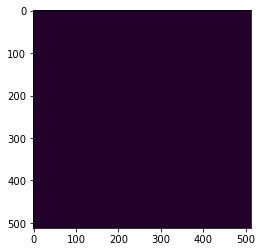

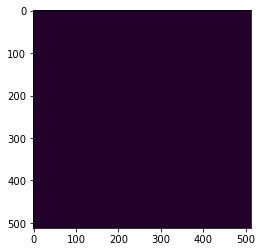

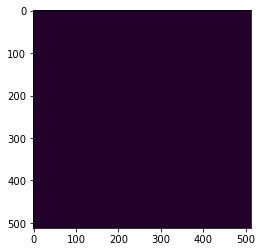

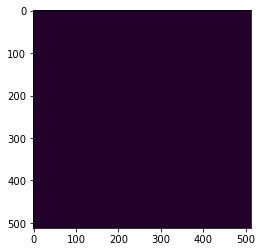

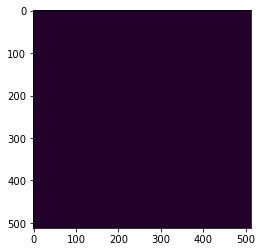

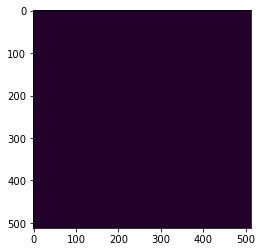

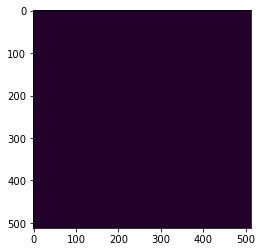

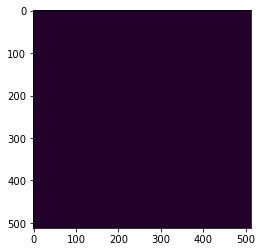

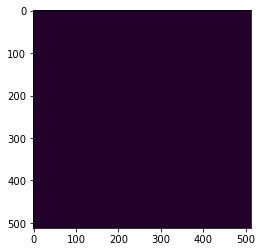

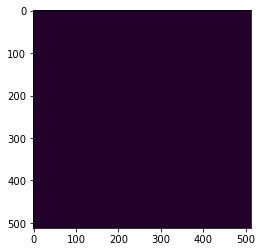

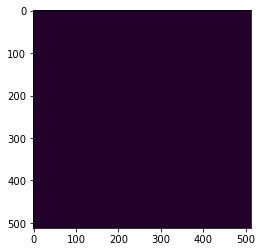

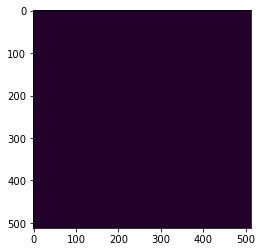

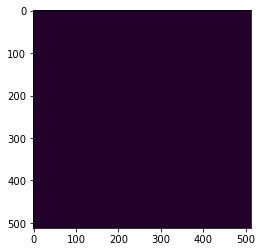

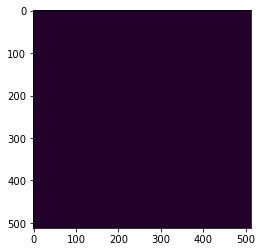

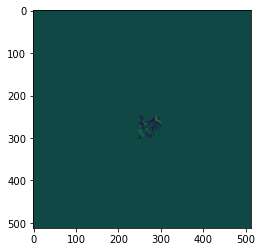

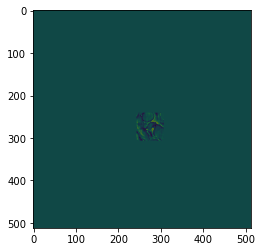

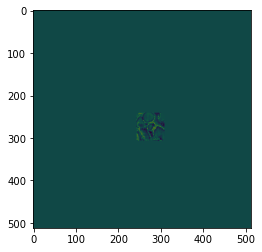

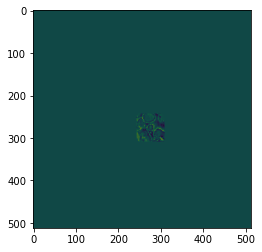

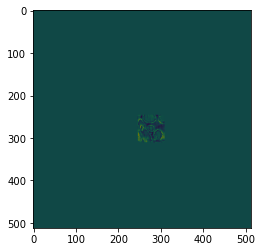

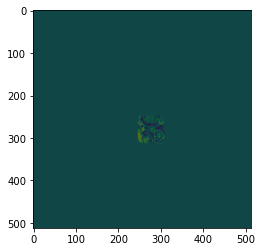

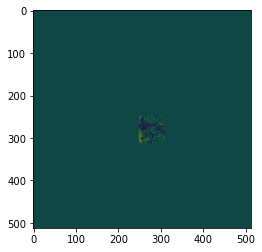

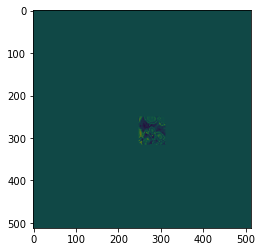

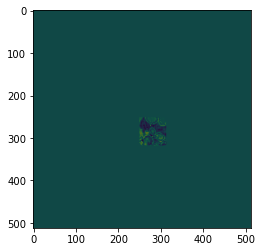

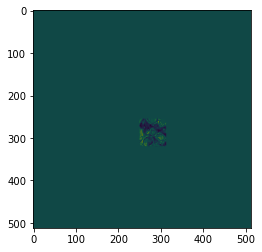

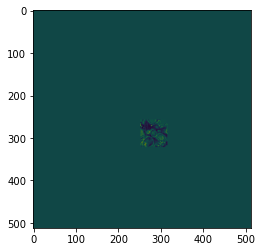

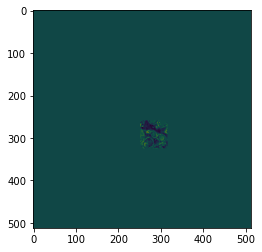

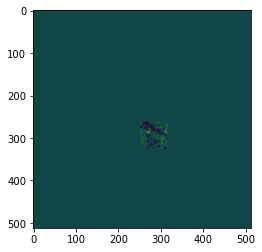

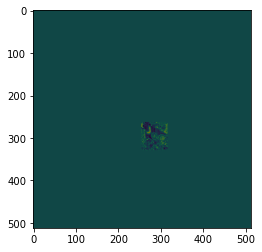

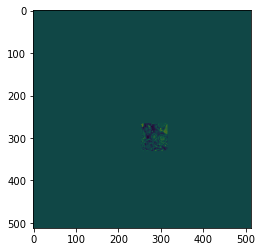

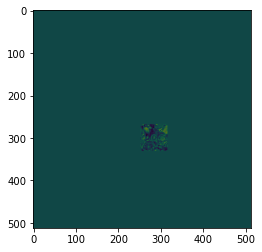

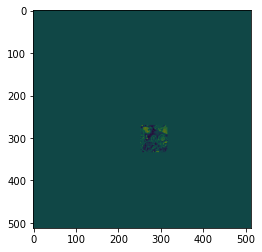

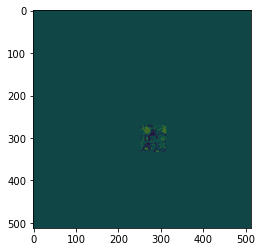

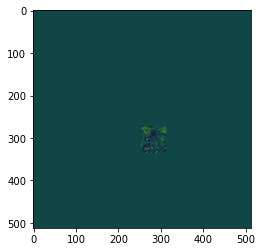

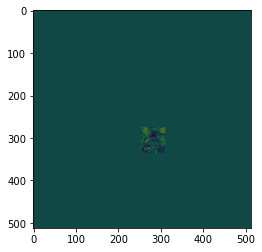

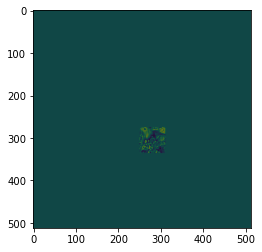

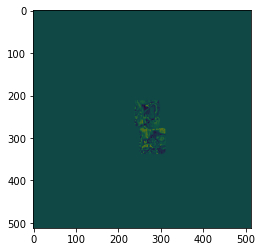

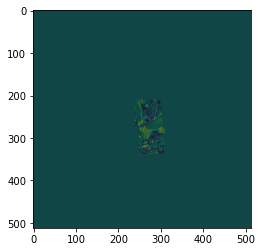

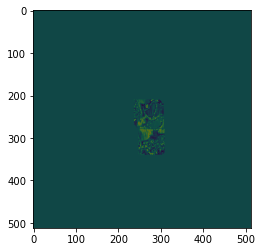

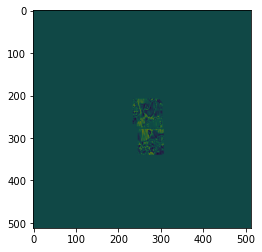

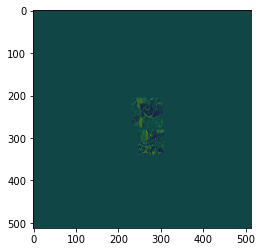

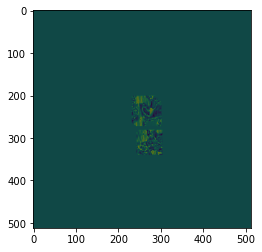

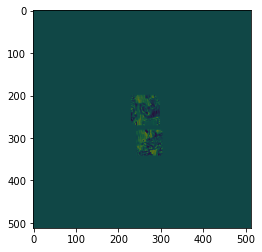

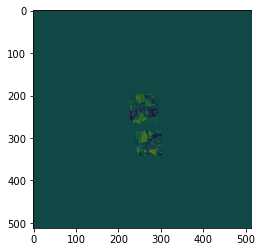

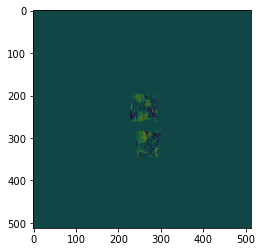

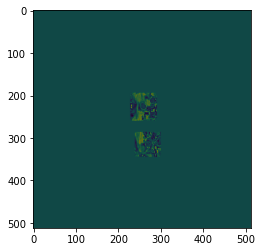

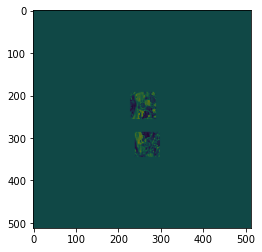

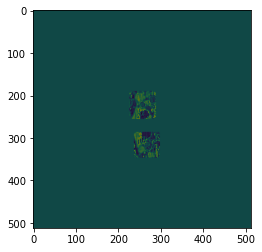

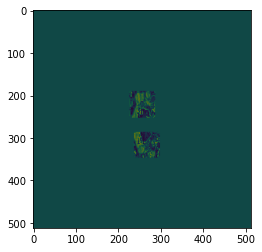

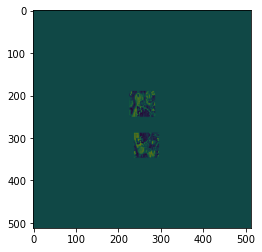

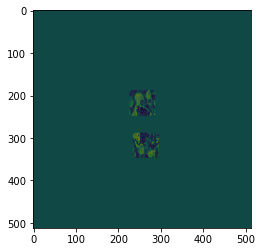

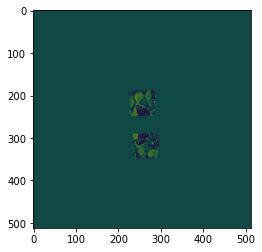

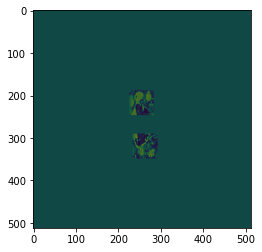

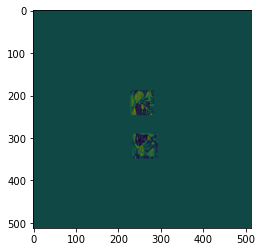

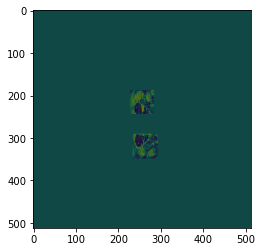

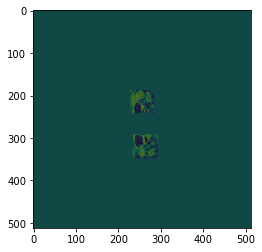

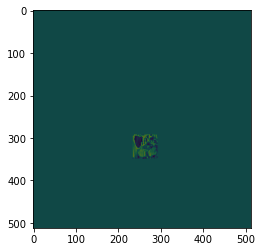

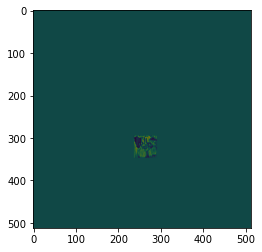

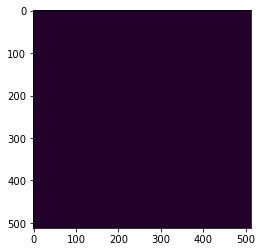

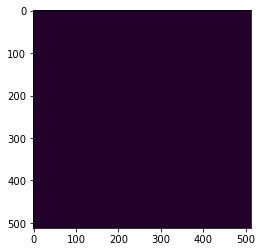

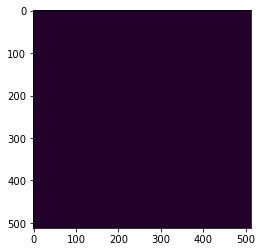

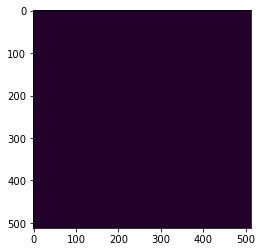

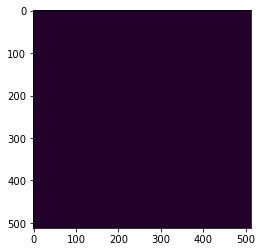

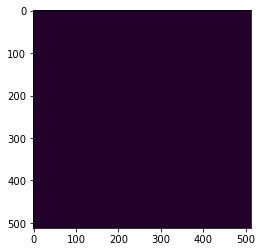

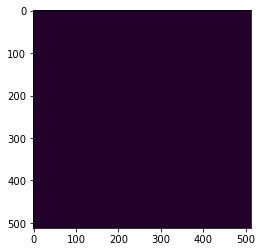

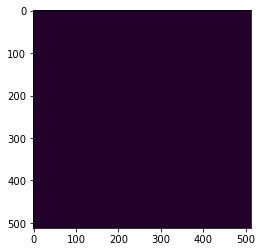

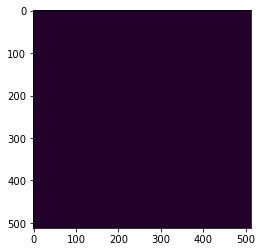

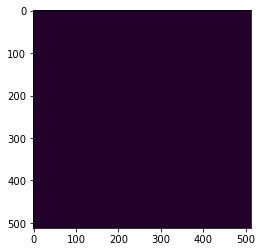

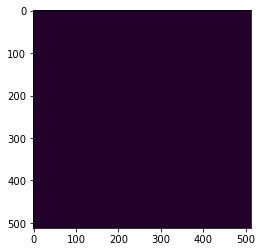

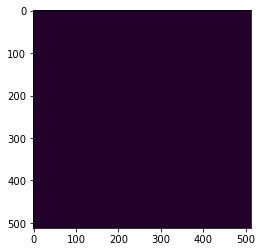

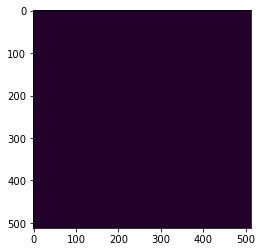

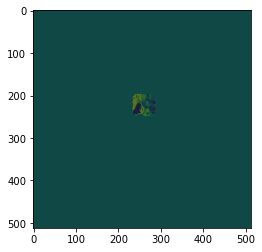

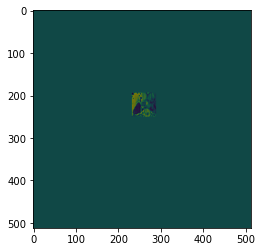

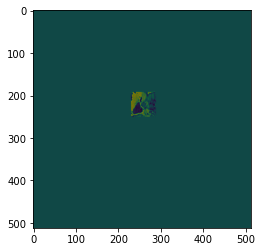

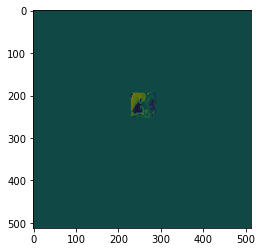

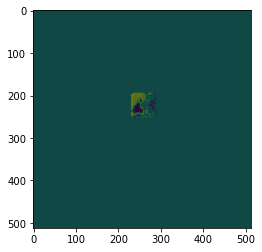

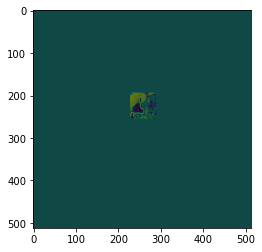

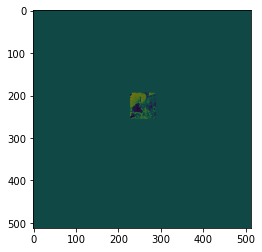

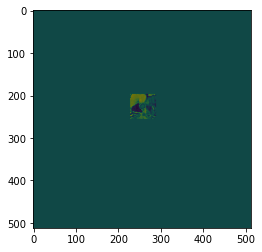

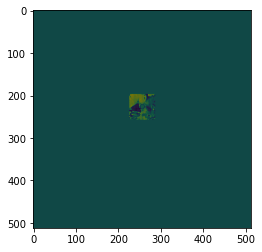

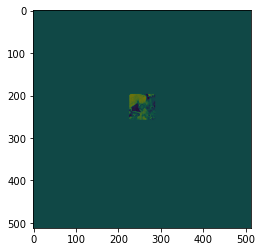

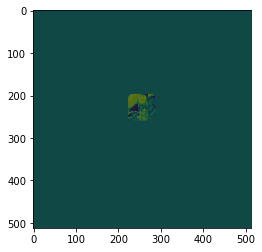

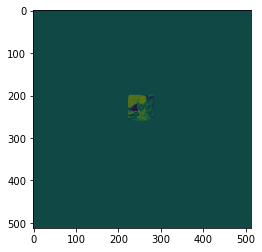

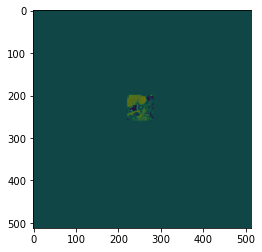

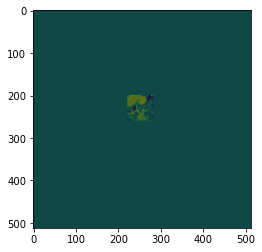

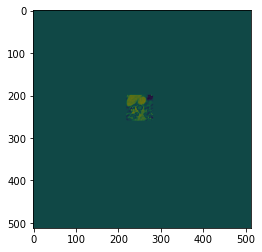

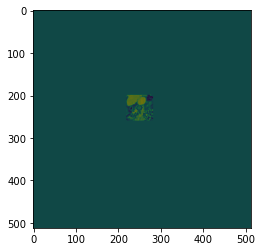

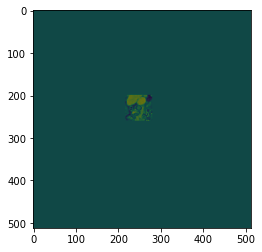

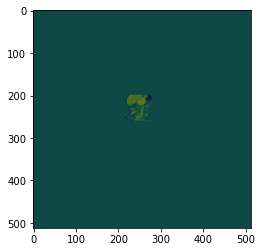

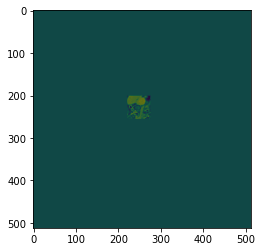

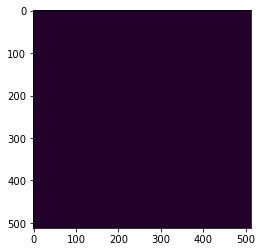

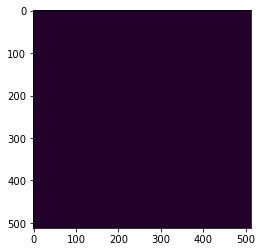

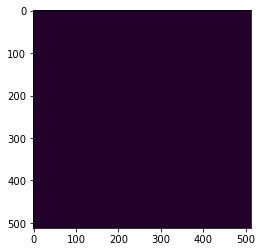

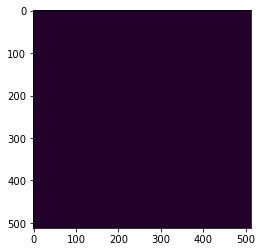

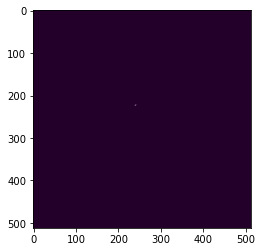

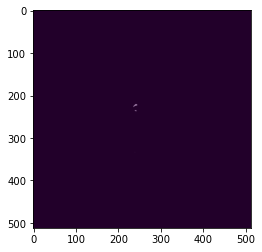

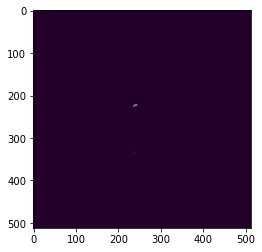

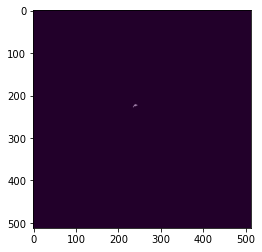

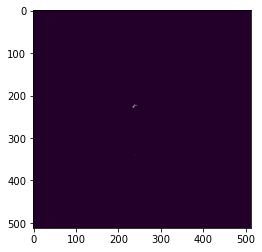

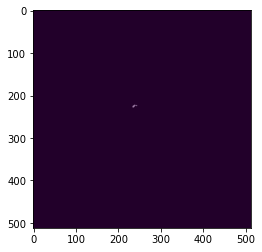

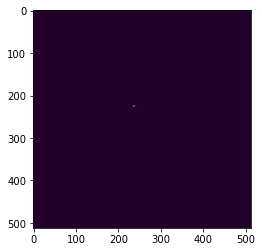

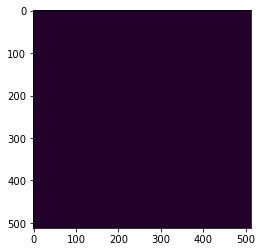

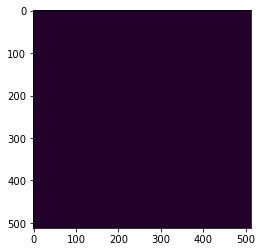

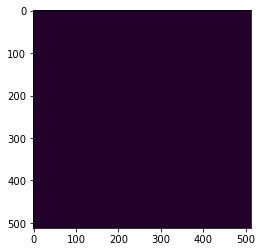

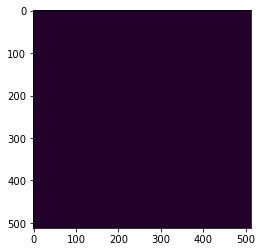

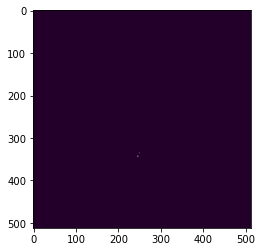

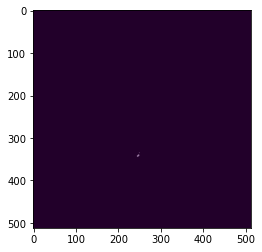

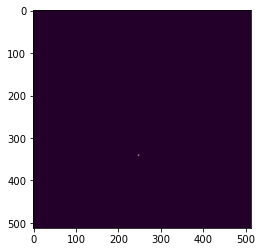

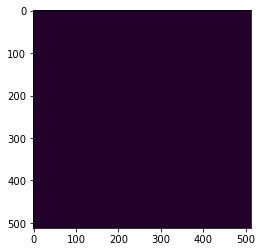

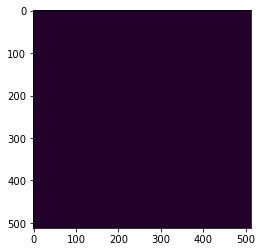

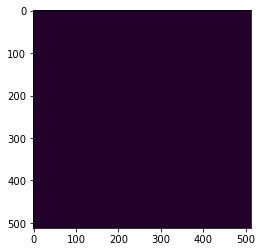

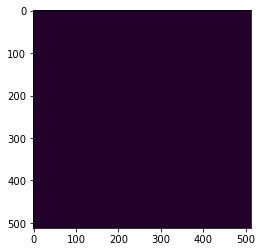

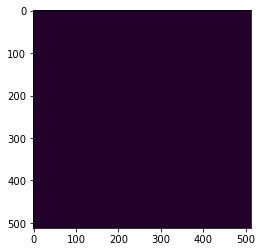

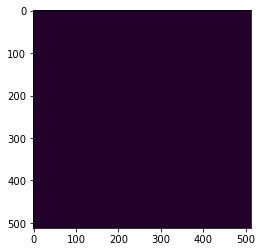

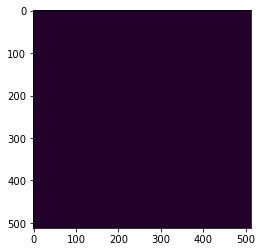

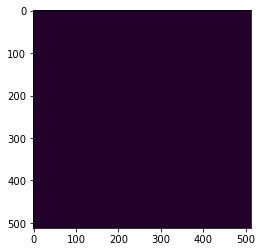

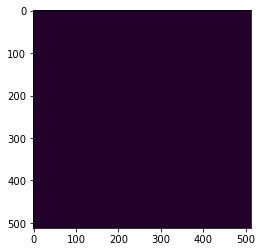

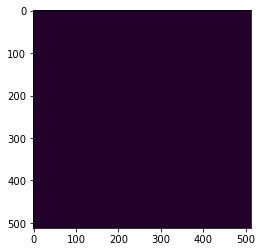

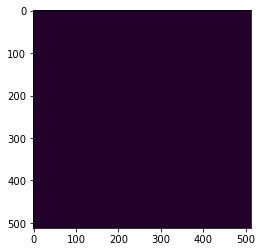

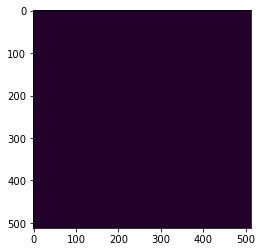

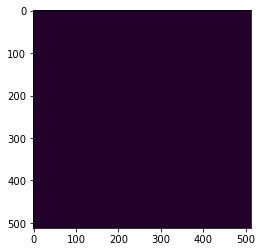

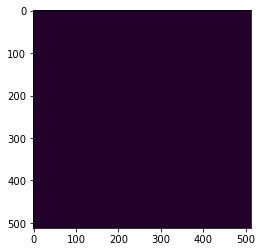

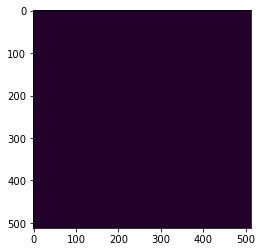

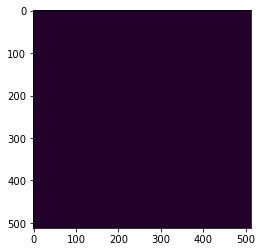

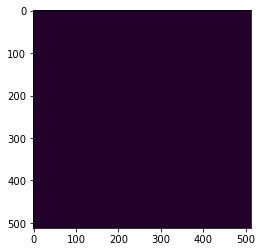

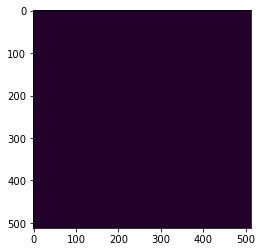

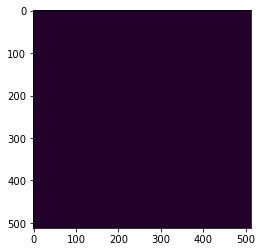

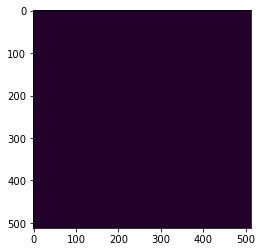

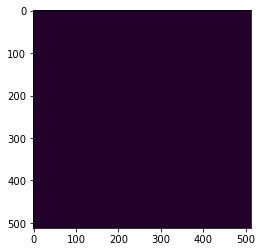

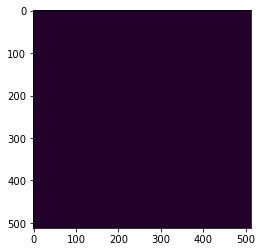

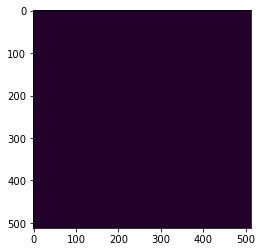

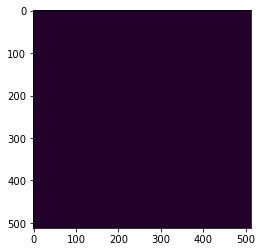

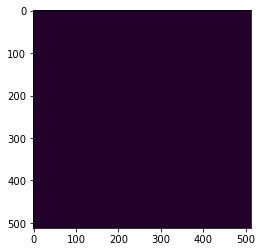

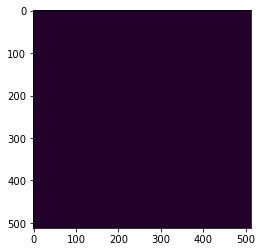

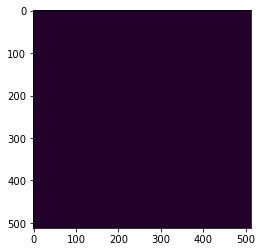

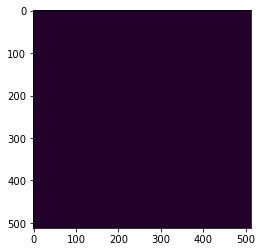

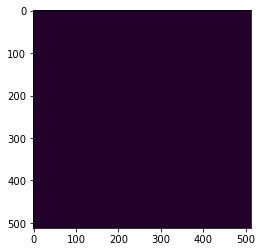

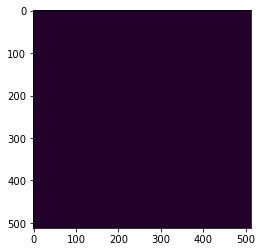

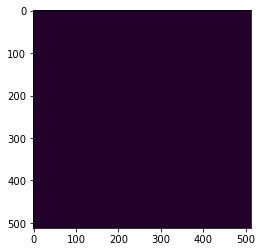

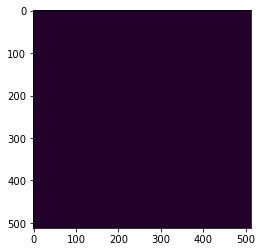

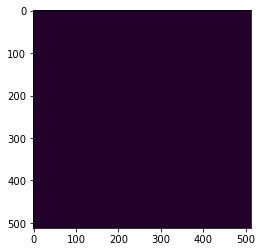

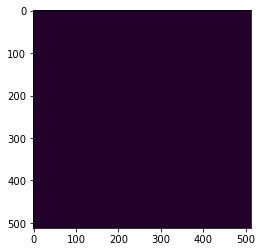

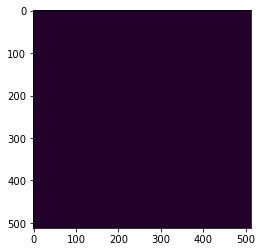

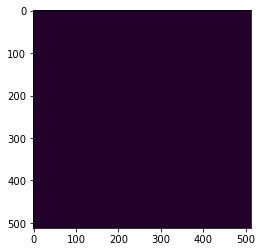

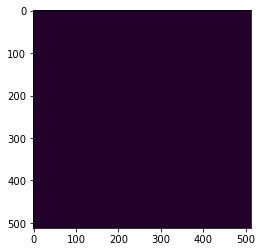

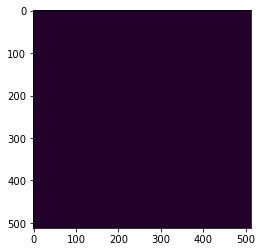

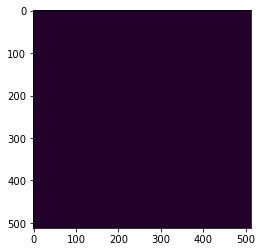

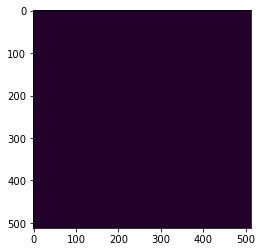

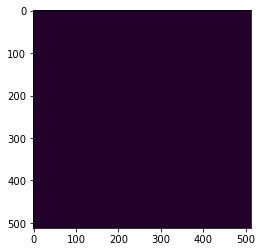

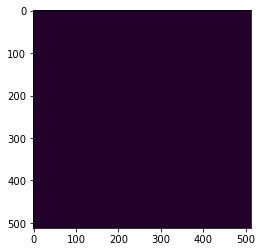

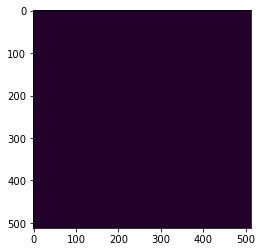

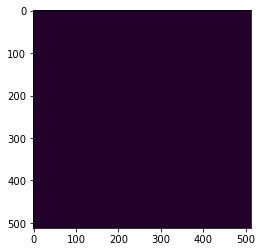

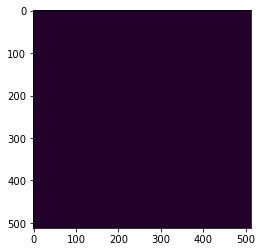

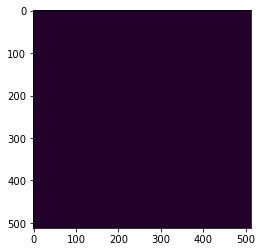

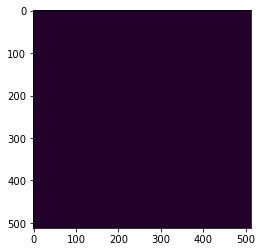

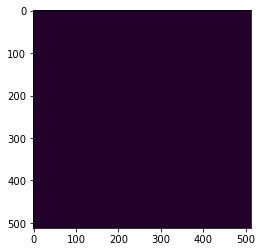

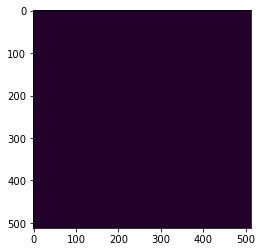

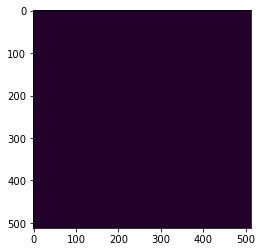

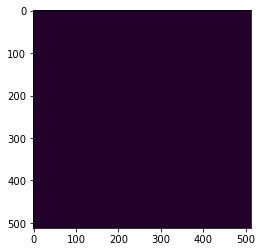

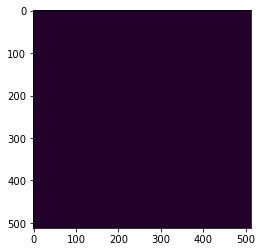

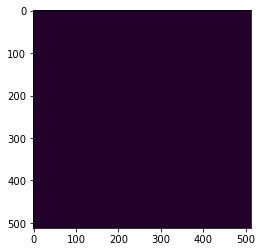

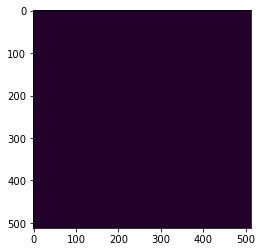

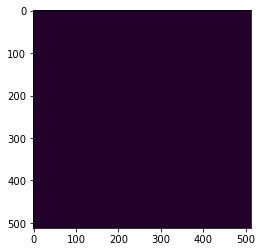

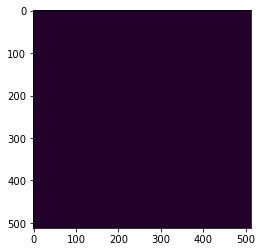

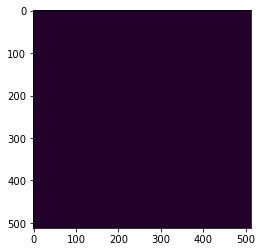

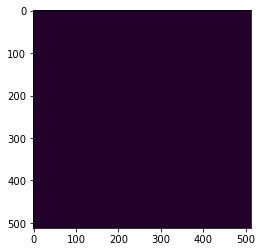

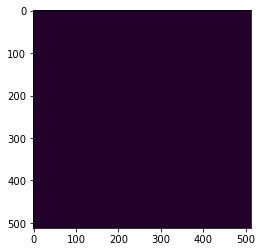

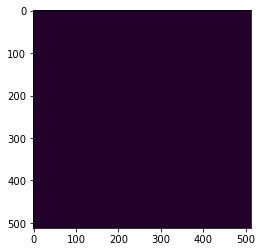

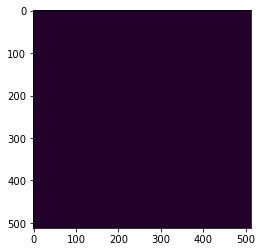

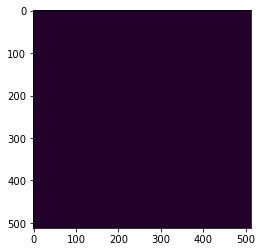

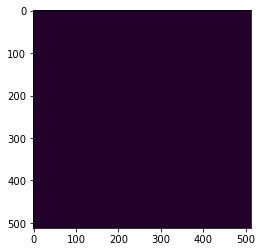

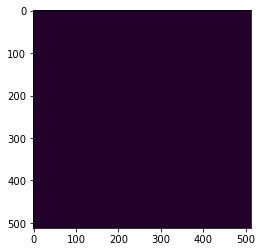

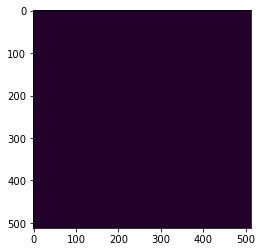

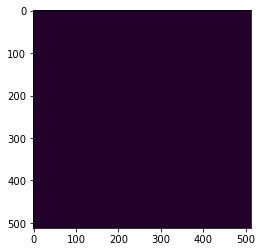

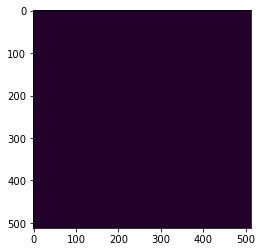

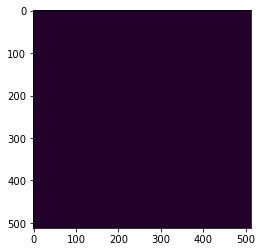

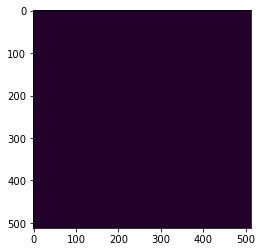

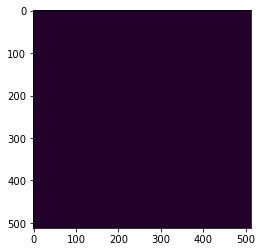

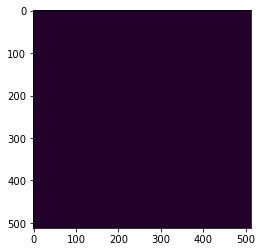

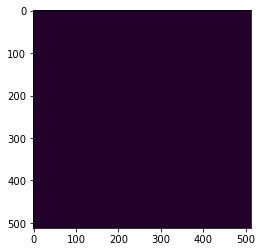

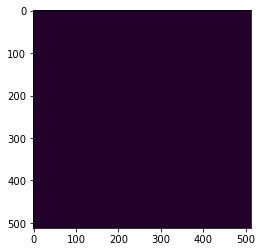

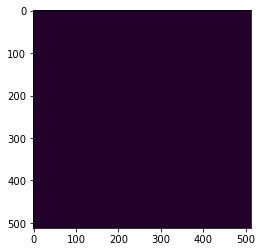

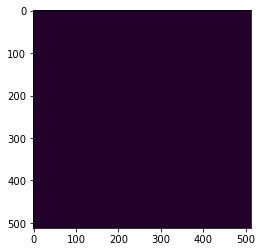

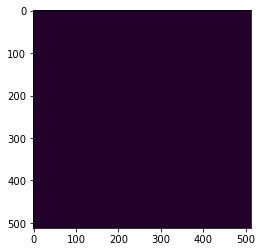

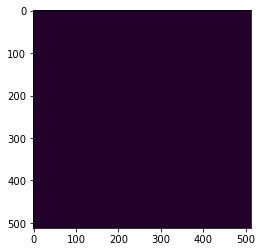

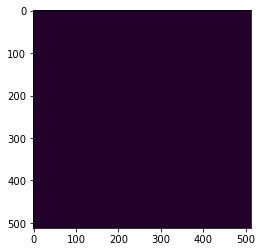

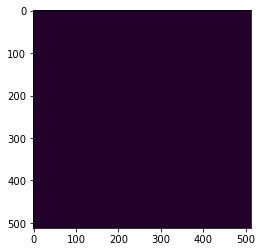

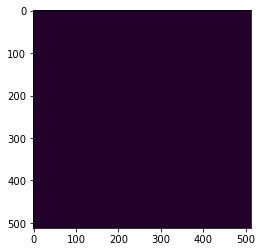

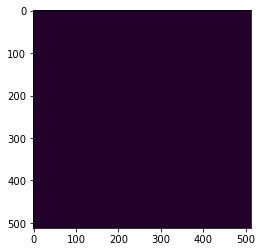

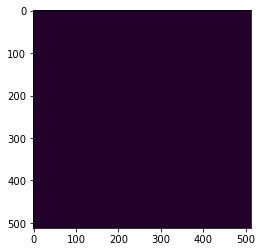

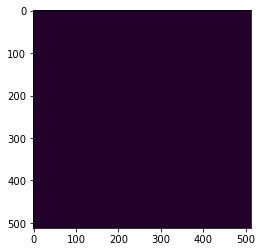

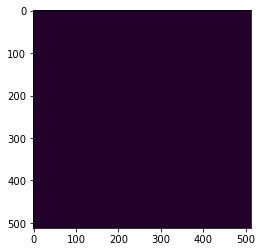

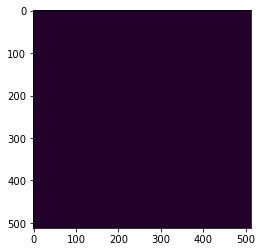

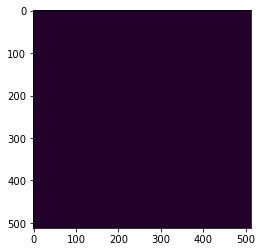

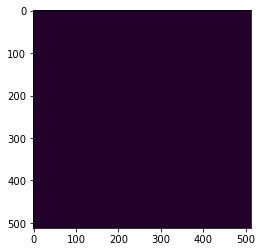

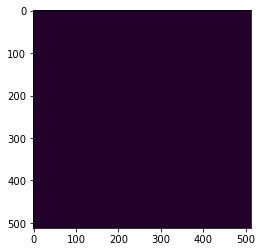

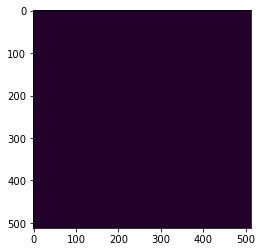

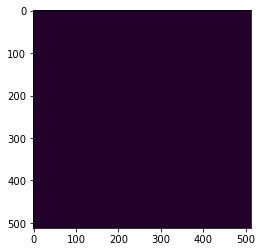

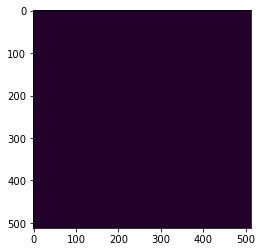

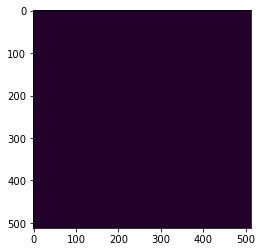

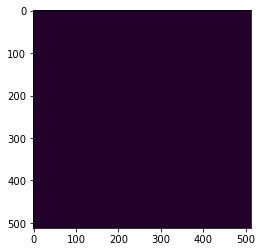

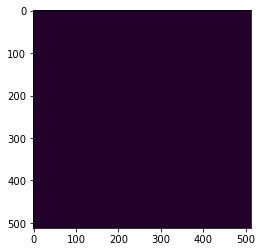

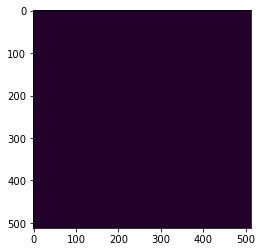

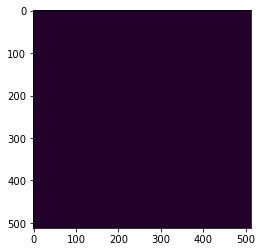

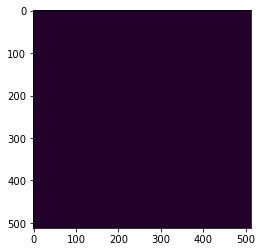

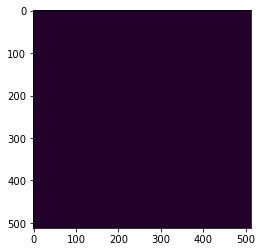

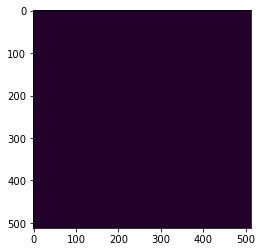

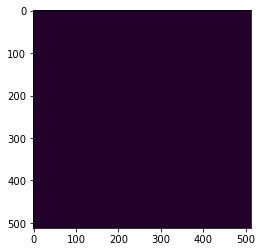

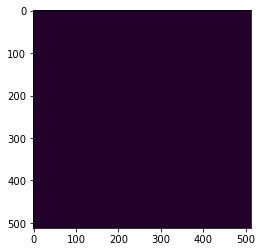

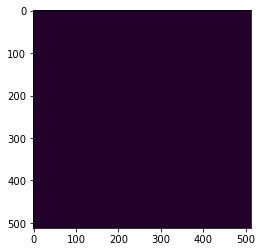

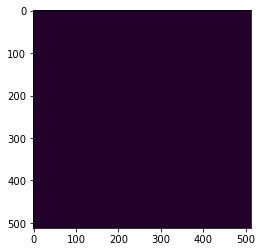

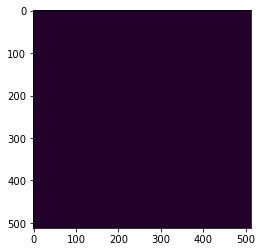

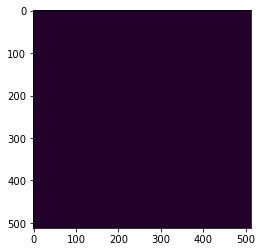

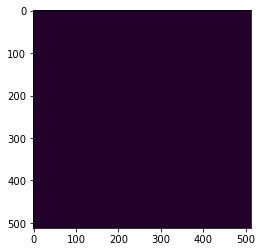

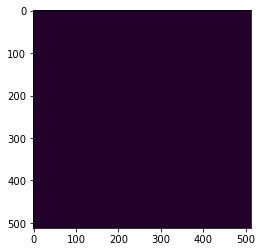

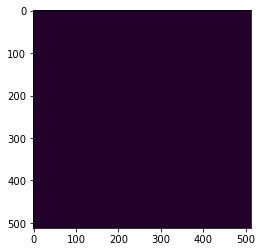

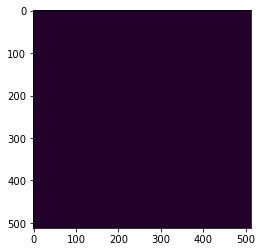

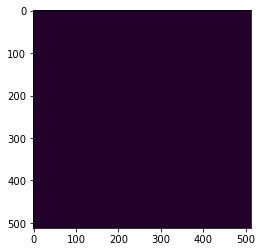

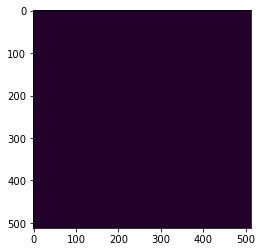

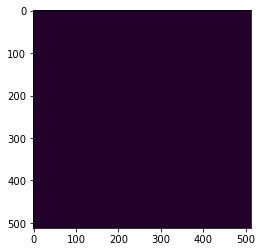

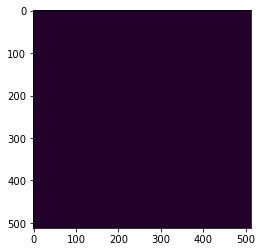

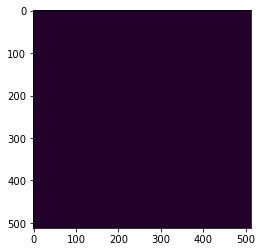

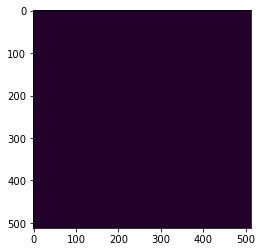

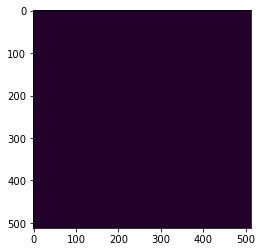

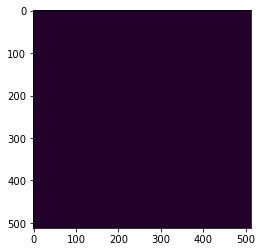

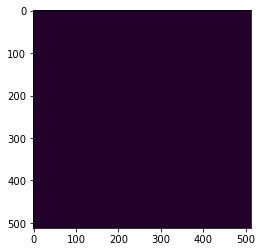

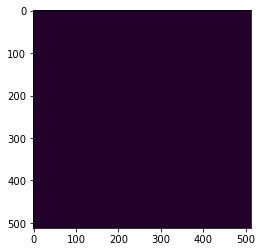

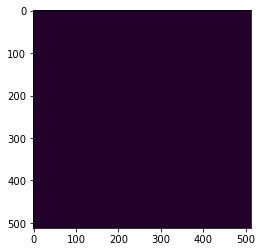

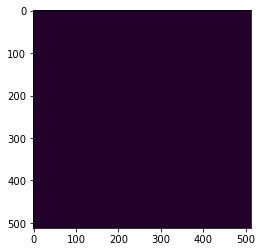

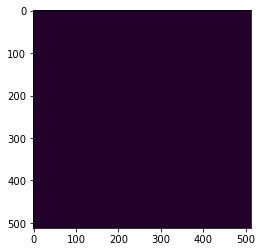

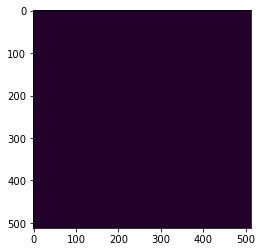

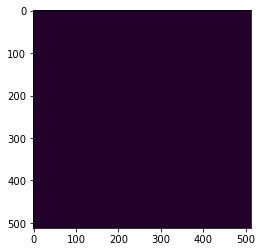

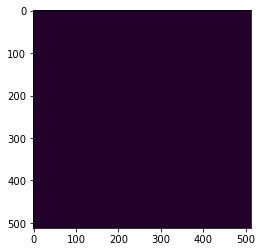

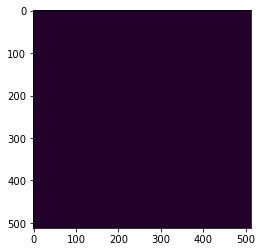

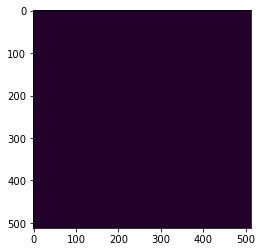

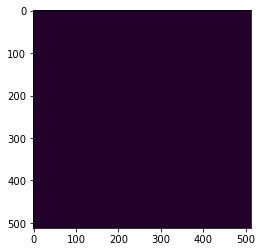

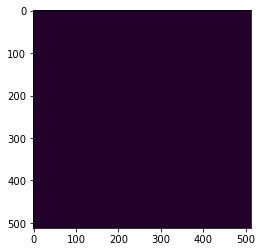

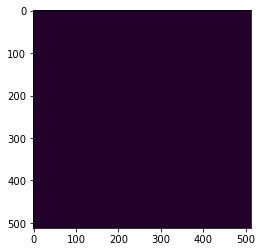

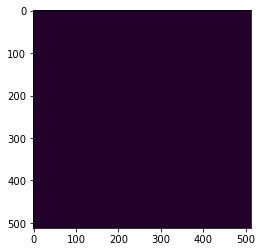

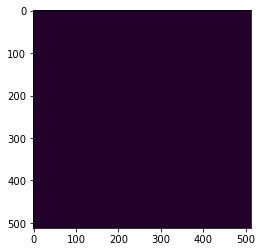

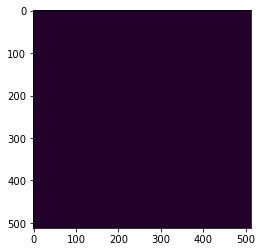

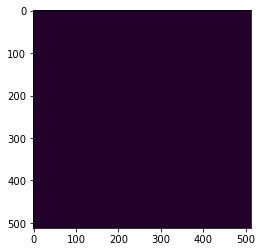

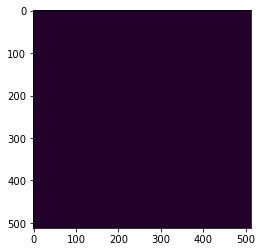

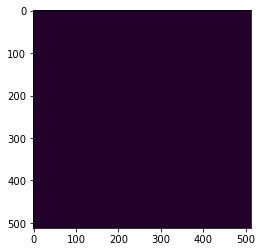

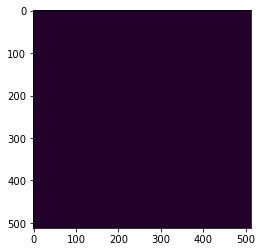

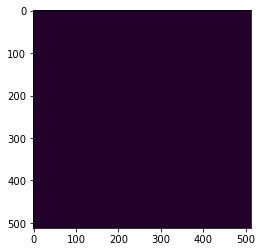

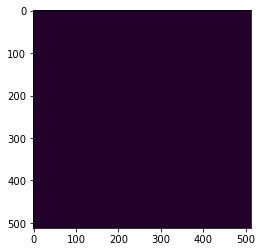

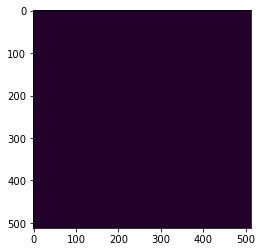

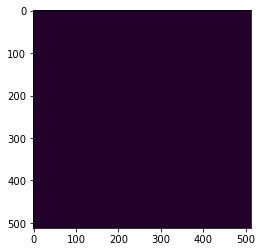

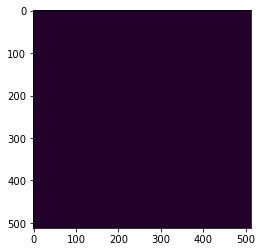

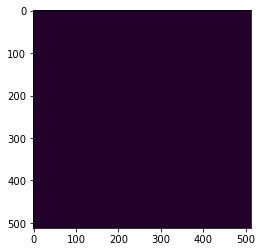

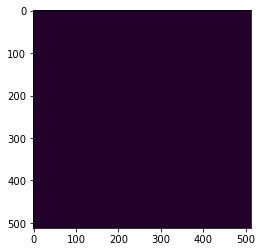

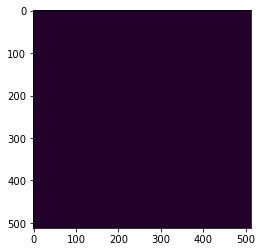

In [35]:
for i in range(image.shape[2]):
    plt.imshow(result[:,:,i])
    plt.imshow(label[:,:,i], cmap='gray', alpha=0.5)
    plt.show()

In [36]:
binary_masks = []

for subfolder in os.listdir(TS_PATH):
    subfolder_path = os.path.join(TS_PATH, subfolder)

    if os.path.isdir(subfolder_path):
        left_image_path = os.path.join(subfolder_path, 'common_carotid_artery_left.nii.gz')
        right_image_path = os.path.join(subfolder_path, 'common_carotid_artery_right.nii.gz')

        if os.path.exists(left_image_path) and os.path.exists(right_image_path):
            left_image = nib.load(left_image_path).get_fdata()
            right_image = nib.load(right_image_path).get_fdata()
            
            carotid_artery = left_image + right_image
            
            kernel = np.ones((50, 50), np.uint8) 
            img_dilation = cv2.dilate(left_image, kernel, iterations=1) 
            binary_mask = (img_dilation > 0).astype(np.uint8) * 255
            binary_masks.append(binary_mask)


In [37]:
ts_id = []
for subfolder in os.listdir(TS_PATH):
    ts_id +=[int(subfolder)]

In [51]:
ts_id

[62,
 15,
 86,
 27,
 50,
 95,
 71,
 49,
 39,
 33,
 92,
 57,
 9,
 12,
 65,
 18,
 16,
 61,
 53,
 24,
 7,
 72,
 96,
 40,
 47,
 75,
 91,
 29,
 23,
 82,
 88,
 66,
 11,
 21,
 2,
 64,
 13,
 32,
 45,
 77,
 93,
 94,
 42,
 35,
 48,
 69,
 87,
 14,
 63,
 5,
 51,
 26,
 55,
 22,
 10,
 83,
 46,
 31,
 90,
 97,
 79,
 73,
 36,
 41,
 60,
 17,
 84,
 25,
 52,
 6]

In [47]:
ids_train=[]
for f in X_train:
    current_id = f.split('.')[0]
    ids_train += [int(current_id)]

In [48]:
len(ids_train)

56

In [52]:
ids_train

[69,
 63,
 88,
 36,
 65,
 45,
 26,
 17,
 21,
 47,
 33,
 97,
 22,
 49,
 82,
 46,
 77,
 27,
 96,
 18,
 90,
 12,
 53,
 62,
 32,
 35,
 5,
 31,
 50,
 73,
 42,
 16,
 92,
 66,
 55,
 41,
 25,
 72,
 84,
 52,
 23,
 87,
 10,
 15,
 9,
 51,
 57,
 40,
 2,
 6,
 64,
 61,
 7,
 86,
 93,
 13]

In [49]:
ids_test=[]
for f in X_test:
    current_id = f.split('.')[0]
    ids_test += [int(current_id)]

In [50]:
len(ids_test)

14

In [53]:
ids_test

[39, 79, 91, 75, 29, 94, 83, 95, 24, 71, 11, 60, 48, 14]

In [55]:
match_train=[]
for i in range(len(ids_train)):
    for j in range(len(ids_train)):
        if ids_train[j] == ts_id[i]:
            #print(i, j, ts_id[i], ids_train[j])
            match_train.append((i,j))
            if len(match_train) == 56:
                break

In [56]:
len(match_train)

44

In [6]:
# for each scan
train_i_patches = []
train_l_patches = []
test_i_patches = []
test_l_patches = []

P=256

In [7]:
symp_data = {}  
asymp_data = {}
patient_id = ''  
count = 0
counts = 0

for i in range(len(y_train)):
    image, header = nrrd.read(DATAPATH + "/" + X_train[i])
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    label, header = nrrd.read(DATAPATH + "/" + y_train[i])
    bbox = mh.bbox(label)
    #print(bbox)


    increase_x = 10
    increase_y = 10
    increase_z = 0
    target_size = P
    
    if target_size:
        widthY = bbox[1]-bbox[0]
        widthX = bbox[3]-bbox[2]
        #print(widthY)
        #print(widthX)

        increase_x = (target_size - widthX) // 2
        increase_y = (target_size - widthY) // 2

        #print(bbox)
        #print(widthY, widthX, increase_x, increase_y)

        bufferY = 0
        if (bbox[0]-increase_y + bbox[1]+increase_y) != target_size:
            bufferY = 1

        bufferX = 0
        if (bbox[2]-increase_x + bbox[3]+increase_x) != target_size:
            bufferX = 1

    # crop label and image according to bbox but make it a little larger
    label_cropped = label[bbox[0]-increase_y:bbox[1]+increase_y+bufferY,
                           bbox[2]-increase_x:bbox[3]+increase_x+bufferX,
                              bbox[4]:bbox[5]]
    image_cropped = image[bbox[0]-increase_y:bbox[1]+increase_y+bufferY,
                           bbox[2]-increase_x:bbox[3]+increase_x+bufferX,
                              bbox[4]:bbox[5]]


    train_i_patches.append(image_cropped)
    train_l_patches.append(label_cropped)


In [8]:
#for i in range(len(train_i_patches)):
#    print(train_i_patches[i].shape)

In [9]:
len(train_i_patches), len(train_l_patches)

(56, 56)

In [10]:
for i in range(len(y_test)):
    image, header = nrrd.read(DATAPATH + "/" + X_test[i])
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    label, header = nrrd.read(DATAPATH + "/" + y_test[i])
    bbox = mh.bbox(label)
    #print(bbox)


    increase_x = 10
    increase_y = 10
    increase_z = 0
    target_size = P
    
    if target_size:
        widthY = bbox[1]-bbox[0]
        widthX = bbox[3]-bbox[2]
        #print(widthY)
        #print(widthX)

        increase_x = (target_size - widthX) // 2
        increase_y = (target_size - widthY) // 2

        #print(bbox)
        #print(widthY, widthX, increase_x, increase_y)

        bufferY = 0
        if (bbox[0]-increase_y + bbox[1]+increase_y) != target_size:
            bufferY = 1

        bufferX = 0
        if (bbox[2]-increase_x + bbox[3]+increase_x) != target_size:
            bufferX = 1

    # crop label and image according to bbox but make it a little larger
    label_cropped = label[bbox[0]-increase_y:bbox[1]+increase_y+bufferY,
                           bbox[2]-increase_x:bbox[3]+increase_x+bufferX,
                              bbox[4]:bbox[5]]
    image_cropped = image[bbox[0]-increase_y:bbox[1]+increase_y+bufferY,
                           bbox[2]-increase_x:bbox[3]+increase_x+bufferX,
                              bbox[4]:bbox[5]]


    test_i_patches.append(image_cropped)
    test_l_patches.append(label_cropped)


In [11]:
for i in range(len(test_l_patches)):
    print(test_l_patches[i].shape)

(256, 257, 10)
(256, 256, 3)
(257, 257, 6)
(256, 257, 7)
(257, 256, 13)
(256, 256, 2)
(256, 257, 25)
(257, 256, 27)
(256, 257, 18)
(256, 256, 4)
(256, 257, 3)
(256, 256, 20)
(256, 257, 19)
(256, 256, 6)


In [12]:
len(test_i_patches), len(test_l_patches)

(14, 14)

In [13]:
test_i_patches[0].shape

(256, 257, 10)

In [14]:
train_i_patches[0].shape

(256, 256, 3)

In [15]:
slices = []
for i in range(len(train_i_patches)):
    for z in range(train_i_patches[i].shape[2]):
        slice_2d = train_i_patches[i][:, :, z]
        slices.append(slice_2d)

In [16]:
slices1 = []
for i in range(len(train_l_patches)):
    for z in range(train_l_patches[i].shape[2]):
        slice_2d = train_l_patches[i][:, :, z]
        slices1.append(slice_2d)
        
new_slices1 = []
for i in range(len(slices1)):
    slicess = np.where(slices1[i] != 0, True, False)
    new_slices1.append(slicess)

In [17]:
len(slices), len(slices1), len(new_slices1)

(652, 652, 652)

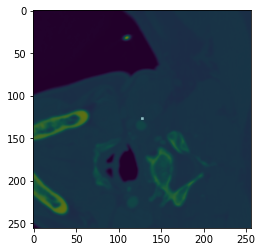

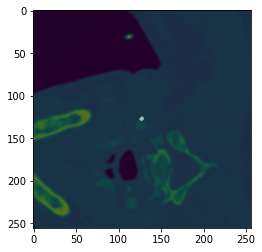

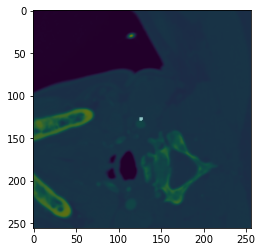

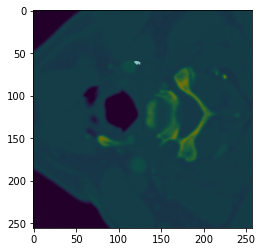

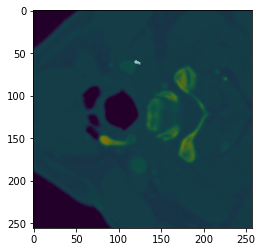

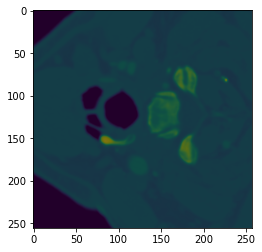

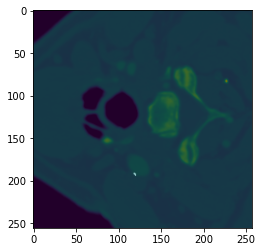

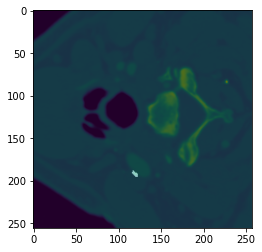

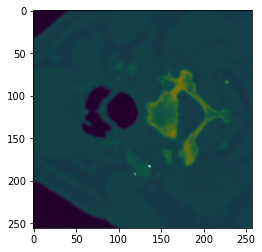

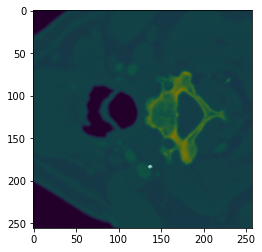

In [18]:
for i in range(10):  
    plt.imshow(slices[i])
    plt.imshow(slices1[i], cmap='gray', alpha=0.5)
    plt.show()

In [19]:
slices2 = []
for i in range(len(test_i_patches)):
    for z in range(test_i_patches[i].shape[2]):
        slice_2d = test_i_patches[i][:, :, z]
        slices2.append(slice_2d)

slices3 = []
for i in range(len(test_l_patches)):
    for z in range(test_l_patches[i].shape[2]):
        slice_2d = test_l_patches[i][:, :, z]
        slices3.append(slice_2d)  

new_slices3 = []
for i in range(len(slices3)):
    slicessss = np.where(slices3[i] != 0, True, False)
    new_slices3.append(slicessss)

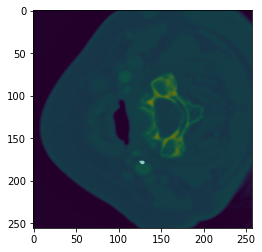

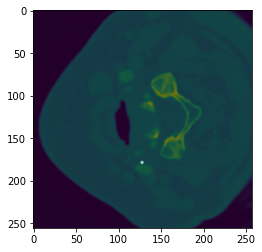

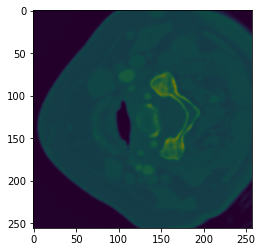

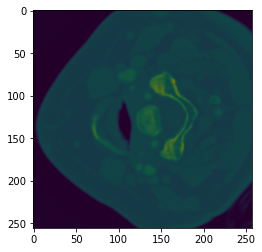

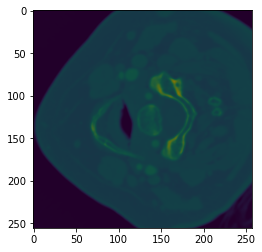

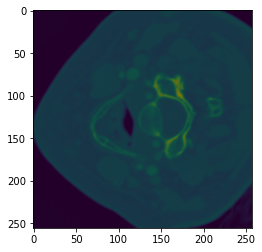

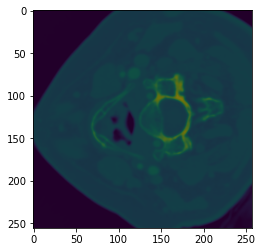

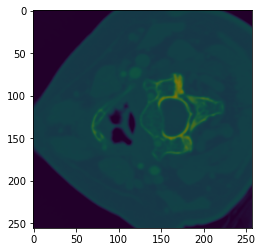

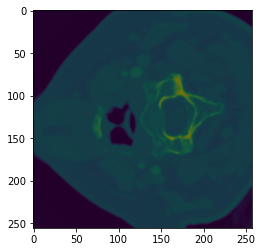

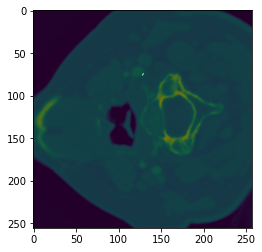

In [20]:
for i in range(10):  
    plt.imshow(slices2[i])
    plt.imshow(slices3[i], cmap='gray', alpha=0.5)
    plt.show()

In [21]:
len(slices2), len(slices3), len(new_slices3)

(163, 163, 163)

In [22]:
def list_to_array(l):
    count = len(l)

    d_y = l[0].shape[0]
    d_x = l[0].shape[1]

    out = np.zeros((count, d_y, d_x,1), dtype=l[0].dtype)

    for i in range(count):
        c_d_y = min(d_y, l[i].shape[0])
        c_d_x = min(d_x, l[i].shape[1])
        
        #print(out[i, 0:c_d_y,0:c_d_x].shape)
        #print(l[i][0:c_d_y,0:c_d_x].reshape(c_d_y, c_d_x, 1).shape)
        out[i, 0:c_d_y,0:c_d_x] = l[i][0:c_d_y,0:c_d_x].reshape(c_d_y, c_d_x, 1)

    return out

In [23]:
train_i_patches_a = list_to_array(slices)

In [24]:
train_i_patches_a.shape

(652, 256, 256, 1)

In [25]:
train_l_patches_a = list_to_array(new_slices1)

In [26]:
train_l_patches_a.shape

(652, 256, 256, 1)

In [27]:
test_i_patches_a = list_to_array(slices2)

In [28]:
test_i_patches_a.shape

(163, 256, 257, 1)

In [29]:
test_l_patches_a = list_to_array(new_slices3)

In [30]:
test_l_patches_a.shape

(163, 256, 257, 1)

In [31]:
symp_count = len(train_i_patches_a)
train_img_patches = np.zeros((symp_count, P,P,1), dtype=train_i_patches_a[0].dtype)

for i,img in enumerate(train_i_patches_a):
    train_img_patches[i] = train_i_patches_a[i,0:P,0:P]

In [32]:
symp_count = len(train_l_patches_a)
train_label_patches = np.zeros((symp_count, P,P,1), dtype=train_l_patches_a[0].dtype)

for i,img in enumerate(train_l_patches_a):
    train_label_patches[i] = train_l_patches_a[i,0:P,0:P]

In [33]:
train_img_patches.shape

(652, 256, 256, 1)

In [34]:
train_label_patches.shape

(652, 256, 256, 1)

In [35]:
symp_count = len(test_i_patches_a)
test_img_patches = np.zeros((symp_count, P,P,1), dtype=test_i_patches_a[0].dtype)

for i,img in enumerate(test_i_patches_a):
    test_img_patches[i] = test_i_patches_a[i,0:P,0:P]

In [36]:
symp_count = len(test_l_patches_a)
test_label_patches = np.zeros((symp_count, P,P,1), dtype=test_l_patches_a[0].dtype)

for i,img in enumerate(test_l_patches_a):
    test_label_patches[i] = test_l_patches_a[i,0:P,0:P]

In [37]:
test_img_patches.shape

(163, 256, 256, 1)

In [38]:
test_label_patches.shape

(163, 256, 256, 1)

In [39]:
slice_to_patient_mapping, last_key = C.Helper.map_and_key(train_l_patches)

In [40]:
X_train_set = train_img_patches[:last_key]
y_train_set = train_label_patches[:last_key]
X_val = train_img_patches[last_key:]
y_val = train_label_patches[last_key:]

In [ ]:
model = C.Helper.create_unet(X_train_set[0].shape)

2023-11-24 05:42:54.184294: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
model, history = C.Helper.train_unet(X_train_set, y_train_set, X_val, y_val, model, epochs=600)

In [ ]:
C.Helper.visualize_graph(history)

In [ ]:
y_pred = C.Helper.prediction(test_img_patches, model)

In [ ]:
C.Helper.visualize_result(test_img_patches, test_label_patches, y_pred)

In [ ]:
C.Helper.evaluate(test_img_patches, test_label_patches, model)